# Avant l'ajout des features avancées


🔍 Training: KNN
Accuracy: 0.4444
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           1       0.50      0.40      0.44         5

    accuracy                           0.44         9
   macro avg       0.45      0.45      0.44         9
weighted avg       0.46      0.44      0.44         9

Matrice de confusion :
 [[2 2]
 [3 2]]

🔍 Training: SVM
Accuracy: 0.5556
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.57      0.80      0.67         5

    accuracy                           0.56         9
   macro avg       0.54      0.53      0.50         9
weighted avg       0.54      0.56      0.52         9

Matrice de confusion :
 [[1 3]
 [1 4]]

🔍 Training: Random Forest
Accuracy: 0.7778
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7778
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9

Matrice de confusion :
 [[3 1]
 [1 4]]

🔍 Training: MLP
Accuracy: 0.7778
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9

Matrice de confusion :
 [[3 1]
 [1 4]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ GRU Accuracy: 0.5556


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ BiLSTM Accuracy: 0.5556

=== Tableau comparatif des accuracies ===
                Modèle  Accuracy
0        Random Forest  0.777778
1              XGBoost  0.777778
2                  MLP  0.777778
3  Logistic Regression  0.666667
4                  GRU  0.555556
5               BiLSTM  0.555556
6                  SVM  0.555556
7                  KNN  0.444444


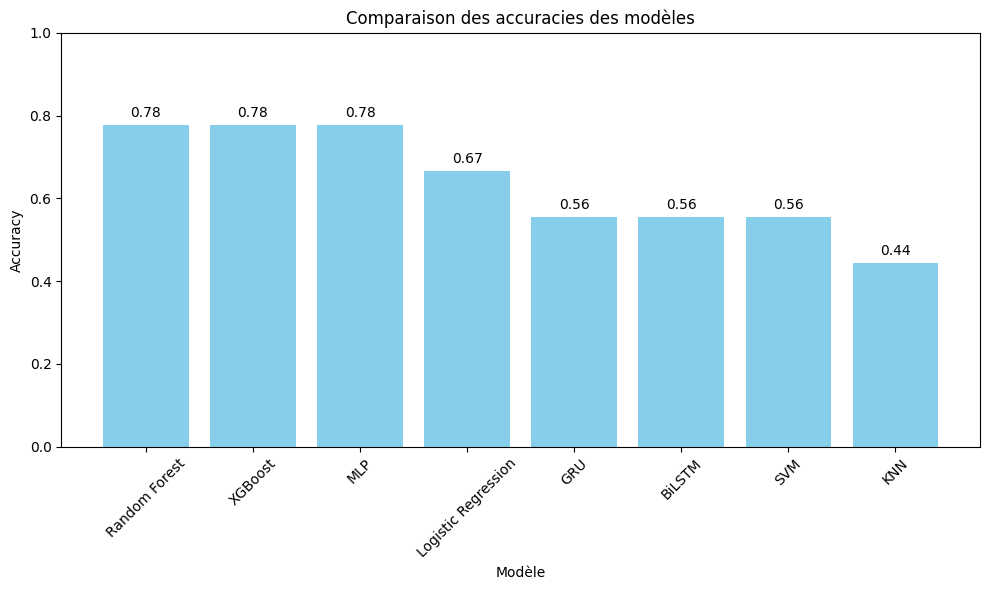

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical

# === 1. Charger les fichiers fusionnés ===
fusion_folder = "/Users/info/Desktop/Stage_Acti-sens/Article/Dataset-FUSION"
all_features = []
labels = []

for filename in os.listdir(fusion_folder):
    if not filename.endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(fusion_folder, filename))
    df = df.select_dtypes(include=np.number).dropna(axis=1, how='all').fillna(df.mean())
    
    features = {}
    for col in df.columns:
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_std'] = df[col].std()
        features[f'{col}_min'] = df[col].min()
        features[f'{col}_max'] = df[col].max()
        features[f'{col}_range'] = df[col].max() - df[col].min()
    
    # Ajouter un label
    label = "AO" if "AO_" in filename else "SO"
    labels.append(label)
    all_features.append(features)

# === 2. Créer DataFrame ===
X = pd.DataFrame(all_features)
y = pd.Series(labels)

# Normaliser
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encodage binaire
y_encoded = (y == "AO").astype(int)

# === 3. Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# === 4. Modèles classiques ===
models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

results = {}

for name, model in models.items():
    print(f"\n🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# === 5. Modèles Profonds (GRU, BiLSTM) ===
X_deep = X_scaled.reshape(-1, 1, X_scaled.shape[1])
y_categorical = to_categorical(y_encoded)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_deep, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42)

def train_deep_model(model_type):
    model = Sequential()
    if model_type == "GRU":
        model.add(GRU(64, input_shape=(1, X_scaled.shape[1])))
    elif model_type == "BiLSTM":
        model.add(Bidirectional(LSTM(64), input_shape=(1, X_scaled.shape[1])))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_d, y_train_d, epochs=20, verbose=0, batch_size=8, validation_split=0.2)
    loss, acc = model.evaluate(X_test_d, y_test_d, verbose=0)
    results[model_type] = acc
    print(f"\n✅ {model_type} Accuracy: {acc:.4f}")

train_deep_model("GRU")
train_deep_model("BiLSTM")

# === 6. Tableau comparatif ===
df_results = pd.DataFrame(list(results.items()), columns=["Modèle", "Accuracy"])
df_results = df_results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n=== Tableau comparatif des accuracies ===")
print(df_results)

# === 7. Histogramme comparatif ===
plt.figure(figsize=(10,6))
plt.bar(df_results["Modèle"], df_results["Accuracy"], color='skyblue')
plt.title("Comparaison des accuracies des modèles")
plt.xlabel("Modèle")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=45)
for i, acc in enumerate(df_results["Accuracy"]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.tight_layout()
plt.show()


# Après l'ajout


🔍 Training: KNN
Accuracy: 0.5556
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.50      0.75      0.60         4

    accuracy                           0.56         9
   macro avg       0.58      0.57      0.55         9
weighted avg       0.59      0.56      0.54         9

Matrice de confusion :
 [[2 3]
 [1 3]]

🔍 Training: SVM
Accuracy: 0.7778
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.67      1.00      0.80         4

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.78         9
weighted avg       0.85      0.78      0.77         9

Matrice de confusion :
 [[3 2]
 [0 4]]

🔍 Training: Random Forest
Accuracy: 0.5556
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.50      0.75      0.60    

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step

✅ GRU Accuracy: 0.8889
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step

✅ BiLSTM Accuracy: 0.8889

=== Tableau comparatif des performances ===
              Model  Accuracy  Precision  Recall       F1
                GRU  0.888889   0.800000    1.00 0.888889
             BiLSTM  0.888889   0.800000    1.00 0.888889
Logistic Regression  0.888889   0.800000    1.00 0.888889
                SVM  0.777778   0.666667    1.00 0.800000
            XGBoost  0.777778   0.666667    1.00 0.800000
                KNN  0.555556   0.500000    0.75 0.600000
      Random Forest  0.555556   0.500000    0.75 0.600000
           LightGBM  0.444444   0.444444    1.00 0.615385
                MLP  0.333333   0.250000    0.25 0.250000


C:\Users\HP\AppData\Local\Temp\ipykernel_25352\3752135132.py:341: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


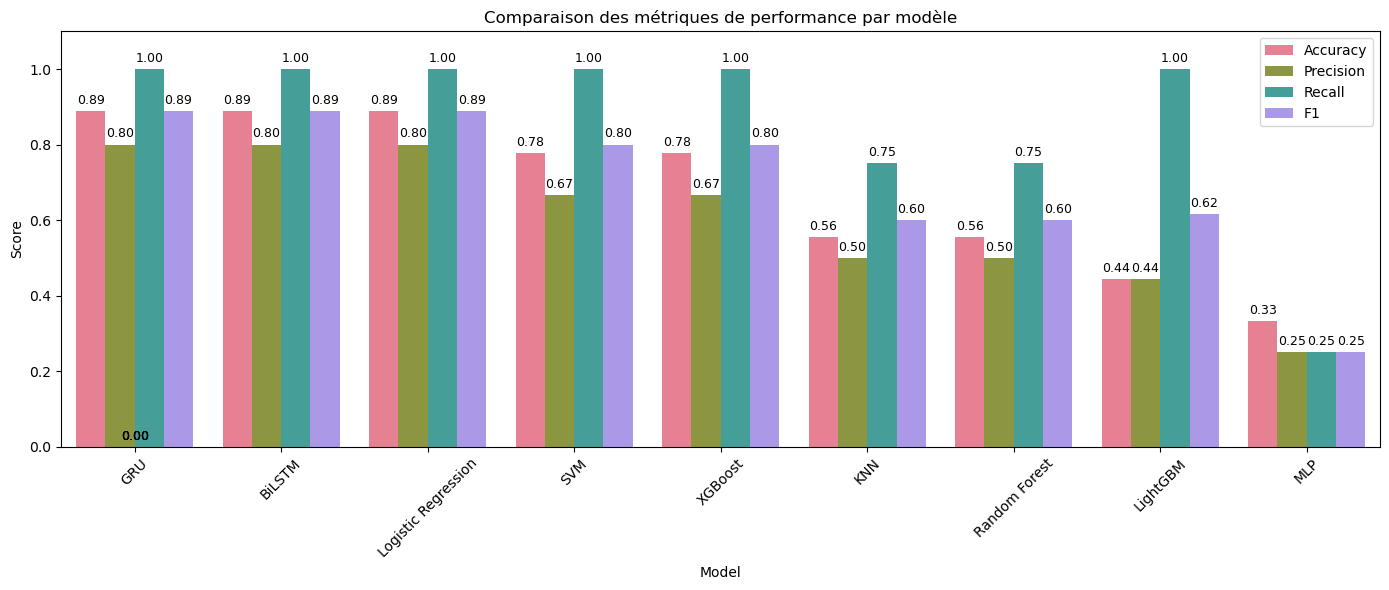

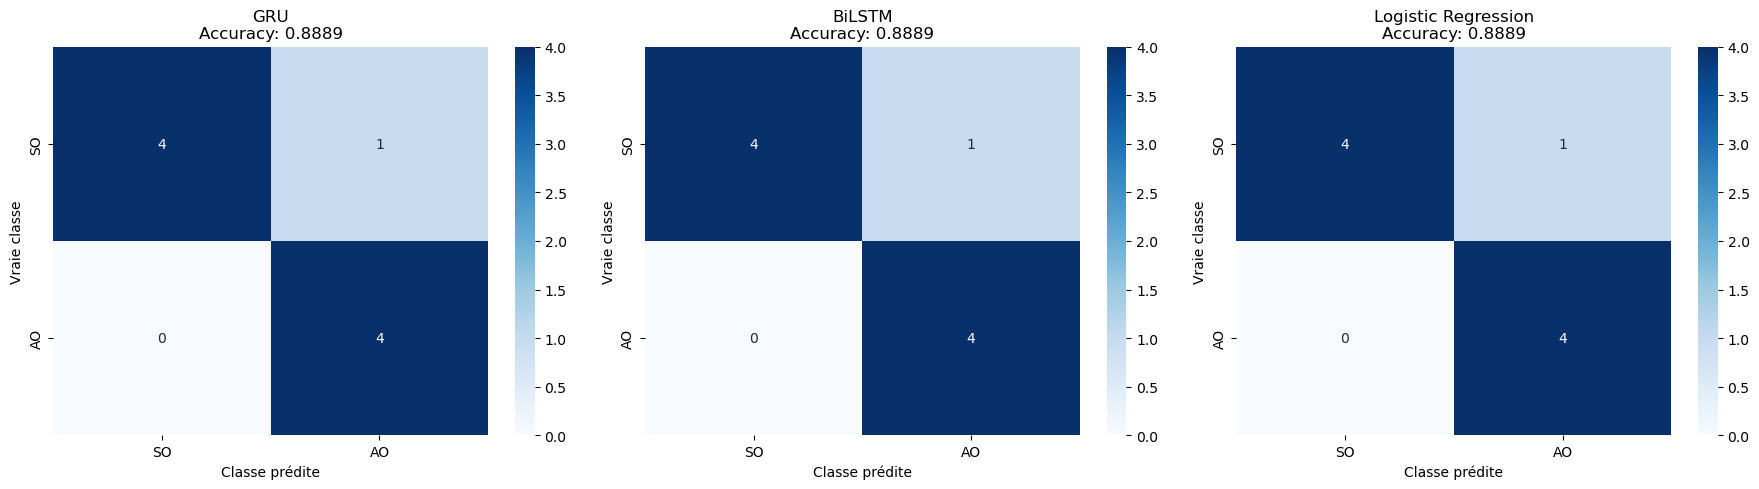

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import entropy
from scipy.signal import welch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.optimizers import Adam

# ============================================
# 🔒 CONFIGURATION POUR LA REPRODUCTIBILITÉ
# ============================================

def set_random_seeds(seed=42):
    """Définit toutes les graines aléatoires pour assurer la reproductibilité"""
    
    # Python random
    import random
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # TensorFlow/Keras
    import tensorflow as tf
    tf.random.set_seed(seed)
    
    # Pour les opérations déterministes sur GPU (optionnel)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)

# Appliquer la configuration de reproductibilité
set_random_seeds(42)

# === 1. Fonctions pour extraire les features ===

def calculate_spectral_features(signal_data, sampling_rate=250):
    features = {}
    signal_data = signal_data.dropna()
    if len(signal_data) < 10:
        return {
            'spectral_power': 0, 'spectral_entropy': 0,
            'power_delta': 0, 'power_theta': 0, 'power_alpha': 0,
            'power_beta': 0, 'power_gamma': 0
        }
    try:
        freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=min(256, len(signal_data)//4))
        features['spectral_power'] = np.trapz(psd, freqs)
        psd_norm = psd / np.sum(psd)
        features['spectral_entropy'] = entropy(psd_norm)
        
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
        for band, (fmin, fmax) in bands.items():
            idx = np.logical_and(freqs >= fmin, freqs <= fmax)
            band_power = np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0
            features[f'power_{band}'] = band_power
    except Exception:
        features = {
            'spectral_power': 0, 'spectral_entropy': 0,
            'power_delta': 0, 'power_theta': 0, 'power_alpha': 0,
            'power_beta': 0, 'power_gamma': 0
        }
    return features

def calculate_rms(signal_data):
    signal_data = signal_data.dropna()
    return np.sqrt(np.mean(signal_data**2)) if len(signal_data) > 0 else 0

def extract_nirs_features(nirs_data):
    features = {}
    
    # Détection automatique des colonnes RED / IR
    red_cols = [c for c in nirs_data.columns if c.startswith('RED')]
    ir_cols  = [c for c in nirs_data.columns if c.startswith('IR')]
    
    for channel in range(1, 17):
        red_col = f'RED{channel}'
        ir_col  = f'IR{channel}'
        
        if red_col not in red_cols or ir_col not in ir_cols:
            continue
        
        red = pd.to_numeric(nirs_data[red_col], errors='coerce').fillna(0)
        ir  = pd.to_numeric(nirs_data[ir_col],  errors='coerce').fillna(0)

        hbo = red - ir
        hbr = ir - red
        prefix = f'C{channel}_'

        features.update({
            f'{prefix}RED_mean': float(np.mean(red)),
            f'{prefix}RED_std':  float(np.std(red)),
            f'{prefix}RED_skew': float(pd.Series(red).skew()),
            f'{prefix}RED_kurtosis': float(pd.Series(red).kurtosis()),
            f'{prefix}IR_mean':  float(np.mean(ir)),
            f'{prefix}IR_std':   float(np.std(ir)),
            f'{prefix}HBO_mean': float(np.mean(hbo)),
            f'{prefix}HBO_std':  float(np.std(hbo)),
            f'{prefix}HBR_mean': float(np.mean(hbr)),
            f'{prefix}HBR_std':  float(np.std(hbr)),
            f'{prefix}RED_median': float(np.median(red)),
            f'{prefix}crossing_points': int(np.sum(np.diff(red > float(np.mean(red))) != 0)),
            f'{prefix}signal_to_noise': float(np.mean(red) / (np.std(red) + 1e-10)),
        })

    return features


def extract_eeg_features(eeg_data):
    features = {}
    
    for col in eeg_data.columns:
        if col.startswith('EEG'):
            signal_data = eeg_data[col].dropna()
            
            # Caractéristiques de base
            features[f'{col}_mean'] = signal_data.mean()
            features[f'{col}_std'] = signal_data.std()
            features[f'{col}_min'] = signal_data.min()
            features[f'{col}_max'] = signal_data.max()
            features[f'{col}_range'] = signal_data.max() - signal_data.min()
            features[f'{col}_rms'] = calculate_rms(signal_data)
            
            # Caractéristiques spectrales
            spectral = calculate_spectral_features(signal_data)
            features.update({
                f'{col}_spectral_power': spectral['spectral_power'],
                f'{col}_spectral_entropy': spectral['spectral_entropy'],
                f'{col}_power_delta': spectral['power_delta'],
                f'{col}_power_theta': spectral['power_theta'],
                f'{col}_power_alpha': spectral['power_alpha'],
                f'{col}_power_beta': spectral['power_beta'],
                f'{col}_power_gamma': spectral['power_gamma']
            })
    
    return features

# === 2. Charger et préparer les données ===
fusion_folder = r"C:\Users\HP\Desktop\datasets\Dataset-EEG&NIRS\Dataset-Early-Fusion"
all_features = []
labels = []

# ⚠️ Trier les fichiers pour garantir un ordre reproductible
for filename in sorted(os.listdir(fusion_folder)):
    if not filename.endswith(".csv"):
        continue

    # Charger le fichier fusionné
    df = pd.read_csv(os.path.join(fusion_folder, filename))
    
    # Convertir les virgules en points et gérer les valeurs non numériques
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
    
    # Remplacer les NaN par la moyenne de la colonne
    df = df.fillna(df.mean())
    
    # Séparer EEG et NIRS
    eeg_data = df[[col for col in df.columns if col.startswith('EEG')]]
    nirs_data = df[[col for col in df.columns if col.startswith(('RED', 'IR'))]]
    
    # Extraire les caractéristiques
    features = {}
    features.update(extract_eeg_features(eeg_data))
    features.update(extract_nirs_features(nirs_data))
    
    # Ajouter le label
    label = "AO" if "AO_" in filename else "SO"
    labels.append(label)
    all_features.append(features)

# Créer le DataFrame final
X = pd.DataFrame(all_features)
y = pd.Series(labels)

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encodage binaire
y_encoded = (y == "AO").astype(int)

# === 3. Split des données ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    stratify=y_encoded, 
    test_size=0.2, 
    random_state=42  # ✅ Reproductibilité garantie
)

# === 4. Modèles classiques avec random_state fixé ===
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance'),  # KNN est déterministe
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, eval_metric='logloss'),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), alpha=0.01, max_iter=500, random_state=42, early_stopping=True),
    "LightGBM": LGBMClassifier(
        random_state=42, 
        verbose=-1,
        force_row_wise=True,  # Pour reproductibilité
        num_threads=1  # Force single-threaded
    )
}

results = {}

for name, model in models.items():
    print(f"\n🔍 Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Stocker les résultats
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'predictions': y_pred,
        'model': model
    }
    
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(classification_report(y_test, y_pred))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# === 5. Modèles Profonds (GRU, BiLSTM) avec reproductibilité ===
X_deep = X_scaled.reshape(-1, 1, X_scaled.shape[1])

# Pas besoin de to_categorical car on utilise sigmoid → binaire
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_deep, y_encoded,  # y_encoded au lieu de one-hot
    test_size=0.2, 
    stratify=y_encoded, 
    random_state=42
)

def build_gru_model(input_shape):
    """Construit un modèle GRU"""
    model = Sequential([
        Input(shape=(1, input_shape)),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def build_bilstm_model(input_shape):
    """Construit un modèle BiLSTM"""
    model = Sequential([
        Input(shape=(1, input_shape)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def train_deep_model(model_type):
    set_random_seeds(42)  # Reproductibilité
    
    if model_type == "GRU":
        model = build_gru_model(X_scaled.shape[1])
    elif model_type == "BiLSTM":
        model = build_bilstm_model(X_scaled.shape[1])
    
    history = model.fit(
        X_train_d, y_train_d, 
        epochs=20, 
        verbose=0,
        batch_size=8,
        validation_split=0.2,
        shuffle=True
    )
    
    # Évaluation
    loss, acc = model.evaluate(X_test_d, y_test_d, verbose=0)
    y_pred_prob = model.predict(X_test_d)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    results[model_type] = {
        'accuracy': acc,
        'precision': precision_score(y_test_d, y_pred),
        'recall': recall_score(y_test_d, y_pred),
        'f1': f1_score(y_test_d, y_pred),
        'predictions': y_pred,
        'model': model,
        'history': history
    }
    
    print(f"\n✅ {model_type} Accuracy: {acc:.4f}")

# Lancement des deux modèles
train_deep_model("GRU")
train_deep_model("BiLSTM")


# === 6. Analyse des résultats ===

# Créer un DataFrame avec tous les résultats
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])
for name, res in results.items():
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1': res['f1']
    }])], ignore_index=True)

# Trier par accuracy
metrics_df = metrics_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print("\n=== Tableau comparatif des performances ===")
print(metrics_df.to_string(index=False))

# === 7. Visualisations ===

# 1. Histogramme comparatif des métriques
plt.figure(figsize=(14, 6))
plot_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
palette = sns.color_palette("husl", 4)

sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric', palette=palette)
plt.title('Comparaison des métriques de performance par modèle')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(loc='upper right')
plt.xticks(rotation=45)

# Ajouter les valeurs sur les barres
for p in plt.gca().patches:
    height = p.get_height()
    if not np.isnan(height):
        plt.gca().annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         fontsize=9, color='black', xytext=(0, 3),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

# 2. Matrices de confusion des 3 meilleurs modèles
top_models = metrics_df.head(3)['Model'].values

plt.figure(figsize=(18, 5))
for i, model_name in enumerate(top_models):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_test, results[model_name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['SO', 'AO'], 
                yticklabels=['SO', 'AO'])
    plt.title(f"{model_name}\nAccuracy: {results[model_name]['accuracy']:.4f}")
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')

plt.tight_layout()
plt.show()

🔄 Démarrage de la validation croisée complète...
📊 Configuration: 5-fold validation croisée stratifiée
🎯 Métriques: accuracy, precision, recall, f1, roc_auc

🚀 Lancement de la validation croisée sur 9 modèles...

📈 Évaluation: KNN
   ✅ Accuracy: 0.6000 ± 0.1499
   📊 F1-Score: 0.6875 ± 0.1042

📈 Évaluation: SVM
   ✅ Accuracy: 0.7417 ± 0.1600
   📊 F1-Score: 0.7416 ± 0.1259

📈 Évaluation: Random Forest
   ✅ Accuracy: 0.5472 ± 0.0461
   📊 F1-Score: 0.4543 ± 0.2301

📈 Évaluation: Logistic Regression
   ✅ Accuracy: 0.6472 ± 0.1124
   📊 F1-Score: 0.6979 ± 0.0874

📈 Évaluation: XGBoost
   ✅ Accuracy: 0.7389 ± 0.0876
   📊 F1-Score: 0.7187 ± 0.1120

📈 Évaluation: MLP
   ✅ Accuracy: 0.4806 ± 0.1371
   📊 F1-Score: 0.5549 ± 0.1737

📈 Évaluation: LightGBM
   ✅ Accuracy: 0.4778 ± 0.0272
   📊 F1-Score: 0.1231 ± 0.2462

📈 Évaluation: GRU
   Fold 1/5
   Fold 2/5
   Fold 3/5
   Fold 4/5
   Fold 5/5
   ✅ Accuracy: 0.5472 ± 0.1154
   📊 F1-Score: 0.6362 ± 0.1046

📈 Évaluation: BiLSTM
   Fold 1/5
   Fold 2/5

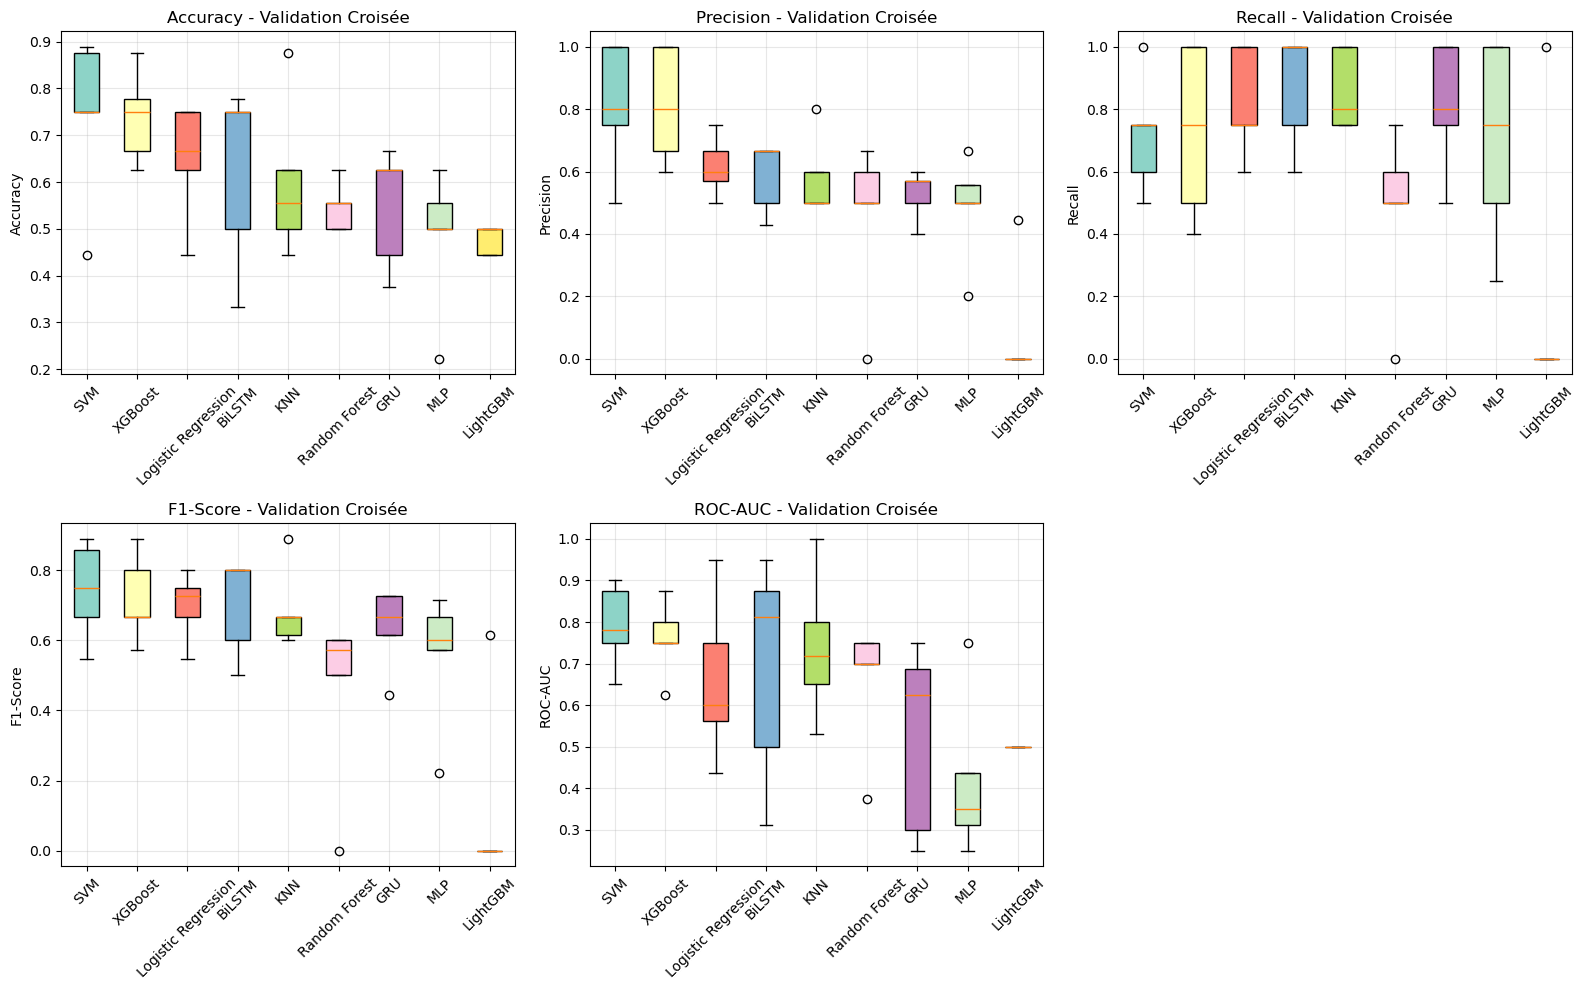


🏆 RÉSUMÉ DE LA VALIDATION CROISÉE
🥇 Meilleur modèle: SVM
   Accuracy: 0.7417 ± 0.1600
   F1-Score: 0.7416 ± 0.1259

📊 Stabilité des modèles (écart-type de l'accuracy):
   1. LightGBM: ±0.0272
   2. Random Forest: ±0.0461
   3. XGBoost: ±0.0876
   4. Logistic Regression: ±0.1124
   5. GRU: ±0.1154

✅ Validation croisée terminée!
📈 9 modèles évalués avec 5-fold CV

INTERVALLE DE CONFIANCE 95 % — ACCURACY (WILSON, VALIDATION CROISÉE)
              Model     Accuracy_CV  Accuracy_Global      IC95_Wilson
                SVM 0.7417 ± 0.1600         0.741667 [0.5717, 0.8389]
            XGBoost 0.7389 ± 0.0876         0.738889 [0.5717, 0.8389]
Logistic Regression 0.6472 ± 0.1124         0.647222 [0.4703, 0.7578]
             BiLSTM 0.6222 ± 0.1762         0.622222 [0.4460, 0.7365]
                KNN 0.6000 ± 0.1499         0.600000 [0.4460, 0.7365]
      Random Forest 0.5472 ± 0.0461         0.547222 [0.3750, 0.6706]
                GRU 0.5472 ± 0.1154         0.547222 [0.3750, 0.6706]
    

In [2]:
# === VALIDATION CROISÉE COMPLÈTE ===
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, cross_validate, 
    validation_curve, learning_curve
)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from math import sqrt
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

class TensorFlowClassifierWrapper(BaseEstimator, ClassifierMixin):
    """
    Wrapper pour les modèles TensorFlow/Keras pour la validation croisée
    """
    def __init__(self, model_type="GRU", epochs=20, batch_size=8, verbose=0):
        self.model_type = model_type
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None
        
    def fit(self, X, y):
        # Réinitialiser les graines pour reproductibilité
        set_random_seeds(42)
        
        # Reshape pour les modèles deep learning
        if len(X.shape) == 2:
            X_reshaped = X.reshape(-1, 1, X.shape[1])
        else:
            X_reshaped = X
            
        y_categorical = to_categorical(y)
        
        # Construire le modèle
        self.model = Sequential()
        
        if self.model_type == "GRU":
            self.model.add(GRU(
                32,                         # ↓ moins de neurones
                dropout=0.3,
                recurrent_dropout=0.3,
                input_shape=(1, X.shape[1] if len(X.shape) == 2 else X.shape[2])
            ))
        
        elif self.model_type == "BiLSTM":
            self.model.add(Bidirectional(
                LSTM(
                    32,
                    dropout=0.3,
                    recurrent_dropout=0.3
                ),
                input_shape=(1, X.shape[1] if len(X.shape) == 2 else X.shape[2])
            ))
        
        self.model.add(Dense(2, activation='softmax'))
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Entraîner
        self.model.fit(X_reshaped, y_categorical, 
                      epochs=self.epochs, 
                      batch_size=self.batch_size, 
                      verbose=self.verbose,
                      validation_split=0.1)
        return self
    
    def predict(self, X):
        if len(X.shape) == 2:
            X_reshaped = X.reshape(-1, 1, X.shape[1])
        else:
            X_reshaped = X
        predictions = self.model.predict(X_reshaped, verbose=0)
        return np.argmax(predictions, axis=1)
    
    def predict_proba(self, X):
        if len(X.shape) == 2:
            X_reshaped = X.reshape(-1, 1, X.shape[1])
        else:
            X_reshaped = X
        return self.model.predict(X_reshaped, verbose=0)

print("🔄 Démarrage de la validation croisée complète...")

# === 1. CONFIGURATION DE LA VALIDATION CROISÉE ===

# Stratified K-Fold pour maintenir la distribution des classes
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Métriques à évaluer
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print(f"📊 Configuration: {cv_folds}-fold validation croisée stratifiée")
print(f"🎯 Métriques: {', '.join(scoring)}")

# === 2. MODÈLES À ÉVALUER (HYPERPARAMÈTRES ADAPTÉS) ===

cv_models = {

    # ===== Modèles classiques avec régularisation =====
    "KNN": Pipeline([ 
        ('scaler', StandardScaler()), 
        ('classifier', KNeighborsClassifier( 
            n_neighbors=7,        # lisser les prédictions weights='distance' 
        )) 
    ]),

    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(
            kernel='rbf',
            C=1,                 # capacité moyenne
            gamma=0.01,          # frontière flexible
            probability=True,
            random_state=42
        ))
    ]),

    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            max_depth=3,         # régularisation forte pour petit dataset
            min_samples_leaf=8,  # empêche surapprentissage
            max_features='sqrt',
            random_state=42
        ))
    ]),

    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            max_iter=1000,
            C=0.8,               # légère régularisation
            random_state=42
        ))
    ]),

    "XGBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(
            learning_rate=0.05,
            max_depth=3,
            min_child_weight=2,  # réduit surapprentissage
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=100,
            eval_metric='logloss',
            random_state=42,
            n_jobs=1
        ))
    ]),

    # ===== Réseaux de neurones légèrement renforcés =====
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(
            hidden_layer_sizes=(60,),  # un peu plus de neurones
            alpha=0.001,
            max_iter=500,
            early_stopping=True,
            random_state=42
        ))
    ]),

    "LightGBM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(
            learning_rate=0.05,
            max_depth=3,
            num_leaves=22,         # légèrement plus de complexité
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1,
            force_row_wise=True,
            num_threads=1
        ))
    ])
}
# Ajouter les modèles deep learning
cv_models["GRU"] = TensorFlowClassifierWrapper(
    model_type="GRU",
    epochs=12,         # léger ajustement
    batch_size=8,
    verbose=0
)

cv_models["BiLSTM"] = TensorFlowClassifierWrapper(
    model_type="BiLSTM",
    epochs=12,
    batch_size=8,
    verbose=0
)
# === 3. EXÉCUTION DE LA VALIDATION CROISÉE ===

cv_results = {}
detailed_results = {}

print(f"\n🚀 Lancement de la validation croisée sur {len(cv_models)} modèles...")

for name, model in cv_models.items():
    print(f"\n📈 Évaluation: {name}")
    
    try:
        # Validation croisée complète
        if name in ["GRU", "BiLSTM"]:
            # Pour les modèles deep learning, évaluation manuelle
            fold_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
                print(f"   Fold {fold + 1}/{cv_folds}")
                
                X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
                y_train_fold, y_val_fold = y_encoded.iloc[train_idx], y_encoded.iloc[val_idx]
                
                # Normaliser
                scaler_fold = StandardScaler()
                X_train_scaled = scaler_fold.fit_transform(X_train_fold)
                X_val_scaled = scaler_fold.transform(X_val_fold)
                
                # Entraîner et prédire
                model.fit(X_train_scaled, y_train_fold)
                y_pred = model.predict(X_val_scaled)
                y_proba = model.predict_proba(X_val_scaled)[:, 1]
                
                # Calculer les métriques
                fold_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
                fold_scores['precision'].append(precision_score(y_val_fold, y_pred, zero_division=0))
                fold_scores['recall'].append(recall_score(y_val_fold, y_pred, zero_division=0))
                fold_scores['f1'].append(f1_score(y_val_fold, y_pred, zero_division=0))
                
                try:
                    from sklearn.metrics import roc_auc_score
                    fold_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_proba))
                except:
                    fold_scores['roc_auc'].append(0.5)
            
            # Moyennes et écarts-types
            cv_results[name] = {}
            for metric in scoring:
                scores = fold_scores[metric]
                cv_results[name][f'{metric}_mean'] = np.mean(scores)
                cv_results[name][f'{metric}_std'] = np.std(scores)
                cv_results[name][f'{metric}_scores'] = scores
                
        else:
            # Pour les modèles classiques
            cv_scores = cross_validate(
                model, X, y_encoded, 
                cv=skf, 
                scoring=scoring, 
                n_jobs=1,  # Pour reproductibilité
                return_train_score=False
            )
            
            cv_results[name] = {}
            for metric in scoring:
                test_scores = cv_scores[f'test_{metric}']
                cv_results[name][f'{metric}_mean'] = test_scores.mean()
                cv_results[name][f'{metric}_std'] = test_scores.std()
                cv_results[name][f'{metric}_scores'] = test_scores
        
        # Afficher les résultats
        print(f"   ✅ Accuracy: {cv_results[name]['accuracy_mean']:.4f} ± {cv_results[name]['accuracy_std']:.4f}")
        print(f"   📊 F1-Score: {cv_results[name]['f1_mean']:.4f} ± {cv_results[name]['f1_std']:.4f}")
        
    except Exception as e:
        print(f"   ❌ Erreur pour {name}: {str(e)}")
        # Initialiser les résultats par défaut en cas d'erreur
        cv_results[name] = {}
        for metric in scoring:
            cv_results[name][f'{metric}_mean'] = 0
            cv_results[name][f'{metric}_std'] = 0



def wilson_ci(k, n, alpha=0.05):
    if n == 0:
        return 0.0, 0.0
    z = norm.ppf(1 - alpha / 2)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    margin = z * sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return center - margin, center + margin


# === 4. ANALYSE DES RÉSULTATS ===

print(f"\n{'='*50}")
print("📊 RÉSULTATS DE LA VALIDATION CROISÉE")
print(f"{'='*50}")

# Créer un DataFrame des résultats
cv_summary = []
for model_name, scores in cv_results.items():
    cv_summary.append({
        'Model': model_name,
        'Accuracy': f"{scores['accuracy_mean']:.4f} ± {scores['accuracy_std']:.4f}",
        'Precision': f"{scores['precision_mean']:.4f} ± {scores['precision_std']:.4f}",
        'Recall': f"{scores['recall_mean']:.4f} ± {scores['recall_std']:.4f}",
        'F1-Score': f"{scores['f1_mean']:.4f} ± {scores['f1_std']:.4f}",
        'ROC-AUC': f"{scores['roc_auc_mean']:.4f} ± {scores['roc_auc_std']:.4f}",
        'Accuracy_Mean': scores['accuracy_mean'],
        'F1_Mean': scores['f1_mean']
    })

cv_df = pd.DataFrame(cv_summary).sort_values('Accuracy_Mean', ascending=False)
print(cv_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].to_string(index=False))

# === 5. VISUALISATIONS ===

# 5.1 Boxplots des performances par modèle
plt.figure(figsize=(16, 10))

# Préparer les données pour les boxplots
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for i, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    plt.subplot(2, 3, i+1)
    
    data_to_plot = []
    labels_to_plot = []
    
    for model_name in cv_df['Model'].values:
        if f'{metric}_scores' in cv_results[model_name]:
            scores = cv_results[model_name][f'{metric}_scores']
            if isinstance(scores, (list, np.ndarray)) and len(scores) > 0:
                data_to_plot.append(scores)
                labels_to_plot.append(model_name)
    
    if data_to_plot:
        bp = plt.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
        
        # Colorer les boîtes
        colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
    
    plt.title(f'{name} - Validation Croisée')
    plt.ylabel(name)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# === 6. RÉSUMÉ FINAL ===

print(f"\n🏆 RÉSUMÉ DE LA VALIDATION CROISÉE")
print(f"{'='*40}")

best_model = cv_df.iloc[0]
print(f"🥇 Meilleur modèle: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']}")
print(f"   F1-Score: {best_model['F1-Score']}")

print(f"\n📊 Stabilité des modèles (écart-type de l'accuracy):")
stability_ranking = []
for model_name in cv_df['Model'].values:
    std = cv_results[model_name]['accuracy_std']
    stability_ranking.append((model_name, std))

stability_ranking.sort(key=lambda x: x[1])
for i, (model, std) in enumerate(stability_ranking[:5]):
    print(f"   {i+1}. {model}: ±{std:.4f}")

# Optionnel: sauvegarder les résultats
cv_results_df = pd.DataFrame(cv_results).T

print(f"\n✅ Validation croisée terminée!")
print(f"📈 {len(cv_models)} modèles évalués avec {cv_folds}-fold CV")

# ==========================================================
# === IC 95 % de Wilson — Accuracy (tous les modèles CV) ===
# ==========================================================

wilson_results = []

n_samples_total = len(y_encoded)
samples_per_fold = n_samples_total // cv_folds

for model_name, scores in cv_results.items():
    
    if 'accuracy_scores' not in scores:
        continue
    
    acc_scores = scores['accuracy_scores']
    
    # Nombre total de succès (approximation CV)
    total_correct = sum(acc * samples_per_fold for acc in acc_scores)
    total_samples = samples_per_fold * len(acc_scores)
    
    acc_global = total_correct / total_samples
    ci_low, ci_high = wilson_ci(int(total_correct), int(total_samples))
    
    wilson_results.append({
        "Model": model_name,
        "Accuracy_CV": f"{scores['accuracy_mean']:.4f} ± {scores['accuracy_std']:.4f}",
        "Accuracy_Global": acc_global,
        "IC95_Wilson": f"[{ci_low:.4f}, {ci_high:.4f}]"
    })

wilson_df = pd.DataFrame(wilson_results).sort_values(
    "Accuracy_Global", ascending=False
)

print("\n" + "="*90)
print("INTERVALLE DE CONFIANCE 95 % — ACCURACY (WILSON, VALIDATION CROISÉE)")
print("="*90)
print(wilson_df.to_string(index=False))
print("="*90)

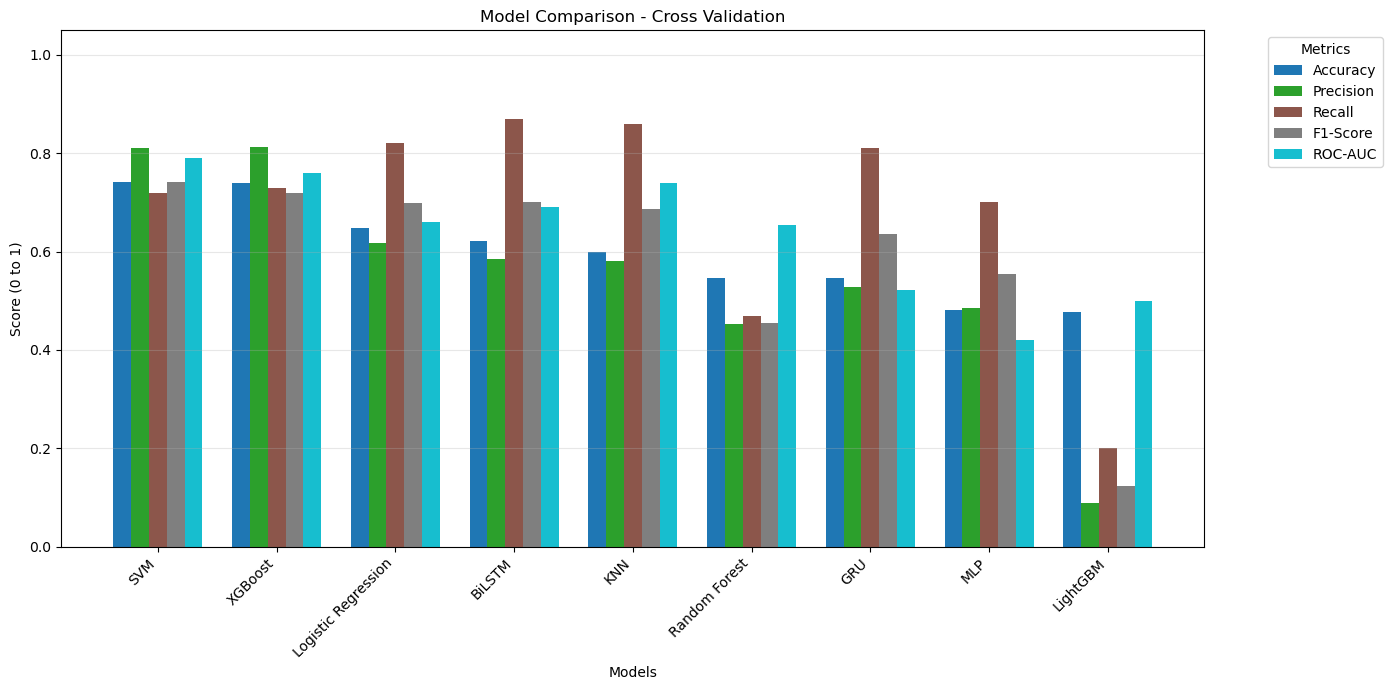

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# === COMPARATIVE BAR CHART OF MODELS (All Metrics) ===

# Metrics and labels
metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Ensure we have numeric "_Mean" columns in cv_df from cv_results
for key, label in zip(metric_keys, metric_labels):
    col_name = f"{label}_Mean"
    cv_df[col_name] = [cv_results[model][f"{key}_mean"] for model in cv_df['Model']]

# Columns to use for plotting
metrics = [f"{label}_Mean" for label in metric_labels]

# X positions for each model
x = np.arange(len(cv_df['Model']))
width = 0.15  # width of each bar

# Colors for each metric
colors = plt.cm.tab10(np.linspace(0, 1, len(metrics)))

fig, ax = plt.subplots(figsize=(14, 7))

# Plot bars for each metric
for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    ax.bar(
        x + i * width - (width * (len(metrics)-1) / 2),
        cv_df[metric],
        width,
        label=label,
        color=color
    )

# Customization
ax.set_ylabel('Score (0 to 1)')
ax.set_xlabel('Models')
ax.set_title('Model Comparison - Cross Validation')
ax.set_xticks(x)
ax.set_xticklabels(cv_df['Model'], rotation=45, ha='right')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

# Legend outside the plot
ax.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [3]:
# === 4bis. ANALYSE TRAIN–TEST GAP (OVERFITTING) ===

print(f"\n{'='*60}")
print("📉 ANALYSE TRAIN–TEST GAP (INDICATEUR DE SURAPPRENTISSAGE)")
print(f"{'='*60}")

gap_results = []

for name, model in cv_models.items():
    print(f"🔍 Analyse: {name}")
    
    try:
        if name in ["GRU", "BiLSTM"]:
            # Calcul manuel train/test
            train_accs, test_accs = [], []
            
            for train_idx, test_idx in skf.split(X, y_encoded):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]
                
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test  = scaler.transform(X_test)
                
                model.fit(X_train, y_train)
                
                train_accs.append(accuracy_score(y_train, model.predict(X_train)))
                test_accs.append(accuracy_score(y_test, model.predict(X_test)))
            
            train_acc = np.mean(train_accs)
            test_acc  = np.mean(test_accs)
            
        else:
            scores = cross_validate(
                model, X, y_encoded,
                cv=skf,
                scoring='accuracy',
                return_train_score=True,
                n_jobs=1
            )
            train_acc = scores['train_score'].mean()
            test_acc  = scores['test_score'].mean()
        
        gap_results.append({
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Gap": train_acc - test_acc
        })
        
    except Exception as e:
        print(f"⚠️ Ignoré ({name}): {e}")

gap_df = pd.DataFrame(gap_results).sort_values("Gap", ascending=False)

print("\n📊 Table X. Train–Test Performance Gaps")
print(gap_df.to_string(index=False, float_format="%.4f"))



📉 ANALYSE TRAIN–TEST GAP (INDICATEUR DE SURAPPRENTISSAGE)
🔍 Analyse: KNN
🔍 Analyse: SVM
🔍 Analyse: Random Forest
🔍 Analyse: Logistic Regression
🔍 Analyse: XGBoost
🔍 Analyse: MLP
🔍 Analyse: LightGBM
🔍 Analyse: GRU
🔍 Analyse: BiLSTM

📊 Table X. Train–Test Performance Gaps
              Model  Train Accuracy  Test Accuracy    Gap
Logistic Regression          1.0000         0.6472 0.3528
                GRU          0.8807         0.5472 0.3335
             BiLSTM          0.9166         0.6222 0.2944
      Random Forest          0.8398         0.5472 0.2925
            XGBoost          0.9939         0.7389 0.2551
                SVM          0.9822         0.7417 0.2405
                MLP          0.6121         0.4806 0.1316
                KNN          0.6373         0.6000 0.0373
           LightGBM          0.5061         0.4778 0.0283
